In [2]:
from utils.compute_metrics import *
from utils.compute_metrics import dfpr_score, dfnr_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd

from SMOTEBoost.SMOTEBoost import SMOTEBoostClassifier
from AdaFair.AdaFair import AdaFairClassifier
from AdaptiveWeights.AdaptiveWeights import AdaptiveWeightsClassifier

from utils.load_and_preprocess import load_kdd, load_compas, load_adult_census, load_bank
from utils.plot_bars import plot_bars

from tqdm import tqdm

from IPython.display import clear_output




In [6]:
base_clf_ab = DecisionTreeClassifier(max_depth=2)
base_clf_sb = DecisionTreeClassifier(max_depth=5)
base_clf_af = DecisionTreeClassifier(max_depth=2)
base_clf_aw = LogisticRegression(solver='liblinear')

random_state = 42

def criterion(y_true, y_pred, sensitive):
    acc = accuracy_score(y_true, y_pred)
    dfpr = dfpr_score(y_true, y_pred, sensitive)
    dfnr = dfnr_score(y_true, y_pred, sensitive)
    return 2 * acc - abs(dfpr) - abs(dfnr)

models = {'AdaBoost':AdaBoostClassifier(base_clf_ab, n_estimators=200),
          'SMOTEBoost':SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
          'AdaFair':AdaFairClassifier(base_clf_af, 4, 20, 500),
          'AdaptiveWeights':AdaptiveWeightsClassifier(base_clf_aw, criterion)}

def get_score_dic(scores):
    scores_dic = {"Accuracy": scores[0],
                  "Bal. Acc.": scores[1],
                  "Eq.Odds": scores[2],
                  "TPR Prot.": scores[3],
                  "TPR Non-prot.": scores[4],
                  "TNR Prot.": scores[5],
                  "TNR Non-prot.": scores[6]}
    return scores_dic


## Adult Census Dataset

In [16]:
adult_census_path = 'datasets/adult.csv'

X, y, sensitive = load_adult_census(adult_census_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)
score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_adult_census = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_adult_census = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Adult Census Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'AdaptiveWeights':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        #else:
        #    model.fit(X_train, y_train, s_train)

        scores = compute_metrics(y_test, y_pred, s_test)
        scores_adult_census = get_score_dic(scores)
        for score, value in scores_adult_census.items():
            results_adult_census.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_adult_census.copy()
save_results.to_csv("results/adult_census_results.csv")


100%|██████████| 10/10 [03:10<00:00, 19.06s/it]


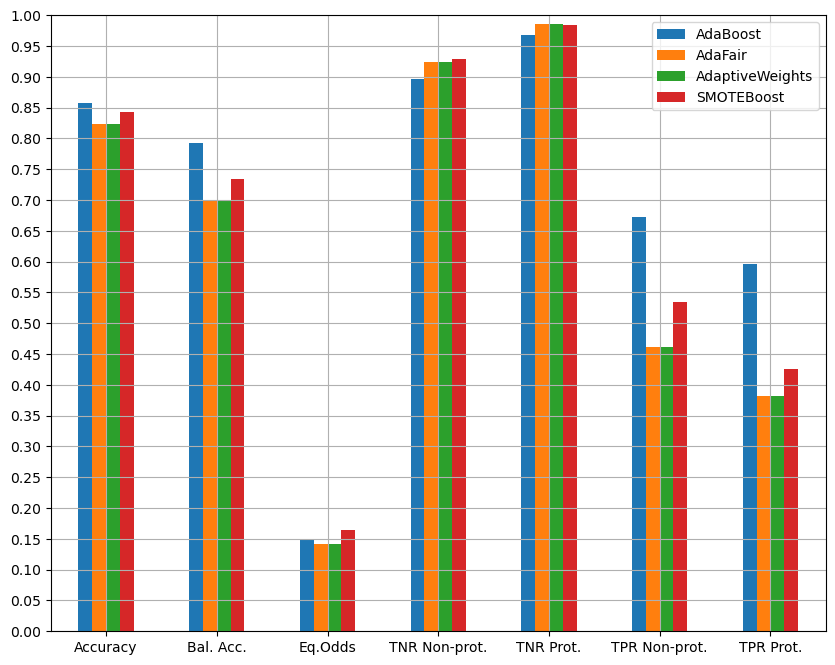

'Mean scores'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.858179,0.792176,0.148831,0.895843,0.968422,0.672046,0.595795
AdaFair,0.823931,0.699010,0.141929,0.924301,0.985633,0.462113,0.381515
AdaptiveWeights,0.823931,0.699010,0.141929,0.924301,0.985633,0.462113,0.381515
SMOTEBoost,0.842683,0.734325,0.163933,0.928836,0.984396,0.534540,0.426167


'Std of scores'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.004133,0.006427,0.025105,0.008361,0.006524,0.014815,0.032403
AdaFair,0.002912,0.007892,0.031542,0.012244,0.004662,0.023744,0.039454
AdaptiveWeights,0.002912,0.007892,0.031542,0.012244,0.004662,0.023744,0.039454
SMOTEBoost,0.009231,0.023640,0.052068,0.013902,0.007595,0.058456,0.048315


In [4]:
results_adult_census = pd.read_csv("results/adult_census_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_adult_census)
display('Mean scores for Adult Census Dataset', mean)
display('Std of scores for Adult Census Dataset', std)

## Bank Dataset

In [7]:
bank_path = 'datasets/bank.csv'
X, y, sensitive = load_bank(bank_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)
score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_bank = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_bank = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Bank Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'AdaptiveWeights':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        #else:
        #    model.fit(X_train, y_train, s_train)

        scores = compute_metrics(y_test, y_pred, s_test)
        scores_bank= get_score_dic(scores)
        for score, value in scores_bank.items():
            results_bank.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_bank.copy()
save_results.to_csv("results/bank_results.csv")

100%|██████████| 10/10 [02:27<00:00, 14.78s/it]


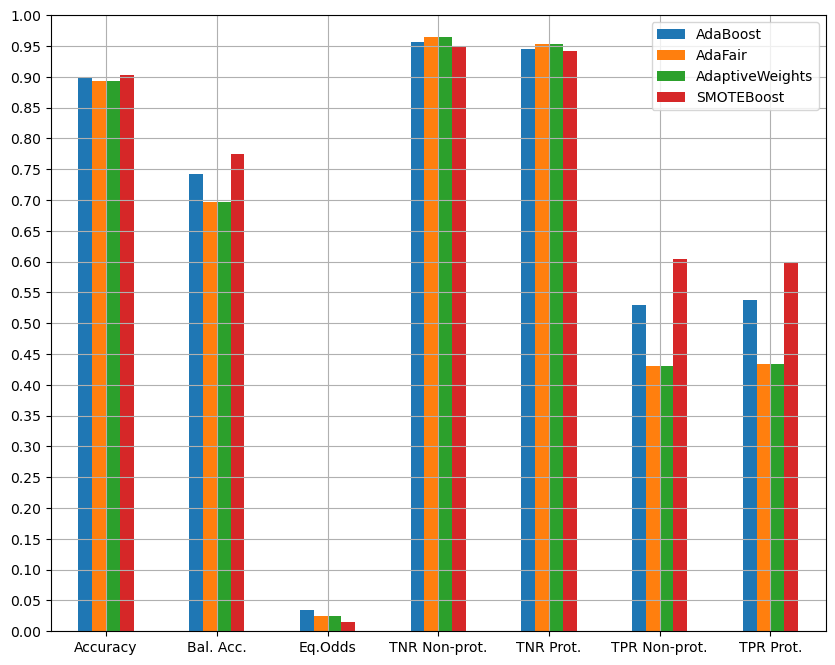

'Mean scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.898780,0.742809,0.034969,0.956815,0.944525,0.530280,0.538310
AdaFair,0.893046,0.696076,0.024237,0.964021,0.954010,0.430612,0.434233
AdaptiveWeights,0.893046,0.696076,0.024237,0.964021,0.954010,0.430612,0.434233
SMOTEBoost,0.902676,0.774088,0.015638,0.949700,0.941515,0.603876,0.599702


'Std of scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.002376,0.008606,0.032143,0.004318,0.004687,0.032950,0.029842
AdaFair,0.004849,0.010706,0.014987,0.003973,0.004172,0.026009,0.024161
AdaptiveWeights,0.004849,0.010706,0.014987,0.003973,0.004172,0.026009,0.024161
SMOTEBoost,0.003131,0.033791,0.012228,0.011866,0.016114,0.083009,0.078694


In [8]:
results_bank = pd.read_csv("results/bank_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_bank)
display('Mean scores for Bank dataset', mean)
display('Std of scores for Bank dataset', std)

## KDD Census dataset

In [9]:
kdd_path = 'datasets/kdd_census_income.csv'
X, y, sensitive = load_kdd(kdd_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)
score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_kdd = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_kdd = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training KDD Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'AdaptiveWeights':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        #else:
        #    model.fit(X_train, y_train, s_train)

        scores = compute_metrics(y_test, y_pred, s_test)
        scores_kdd= get_score_dic(scores)
        for score, value in scores_kdd.items():
            results_kdd.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_kdd.copy()
save_results.to_csv("results/kdd_results.csv")

100%|██████████| 10/10 [15:17<00:00, 91.71s/it]


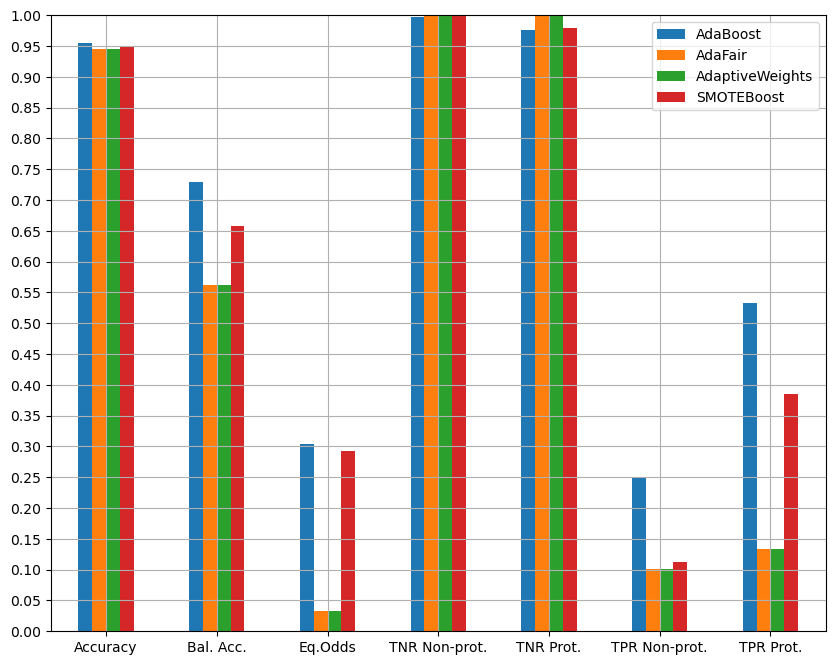

'Mean scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.955157,0.729475,0.304598,0.996787,0.975744,0.249261,0.532817
AdaFair,0.944458,0.562790,0.033255,0.998579,0.998497,0.101027,0.134164
AdaptiveWeights,0.944458,0.562790,0.033255,0.998579,0.998497,0.101027,0.134164
SMOTEBoost,0.948471,0.658230,0.292843,0.998917,0.978603,0.112992,0.385522


'Std of scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.000814,0.005509,0.024830,0.001038,0.002348,0.021986,0.013462
AdaFair,0.000375,0.003989,0.009245,0.000366,0.000211,0.008138,0.009149
AdaptiveWeights,0.000375,0.003989,0.009245,0.000366,0.000211,0.008138,0.009149
SMOTEBoost,0.001505,0.021757,0.069036,0.000747,0.009888,0.010429,0.061222


In [10]:
results_kdd = pd.read_csv("results/kdd_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_kdd)
display('Mean scores for KDD dataset', mean)
display('Std of scores for KDD dataset', std)

## COMPAS dataset

In [11]:
compas_path = 'datasets/compas-scores-two-years_works.csv'
X, y, sensitive = load_compas(compas_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)
score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_compas = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_compas = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training COMPAS Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'AdaptiveWeights':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        #else:
        #    model.fit(X_train, y_train, s_train)

        scores = compute_metrics(y_test, y_pred, s_test)
        scores_compas= get_score_dic(scores)
        for score, value in scores_compas.items():
            results_compas.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_compas.copy()
save_results.to_csv("results/compas_results.csv")

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


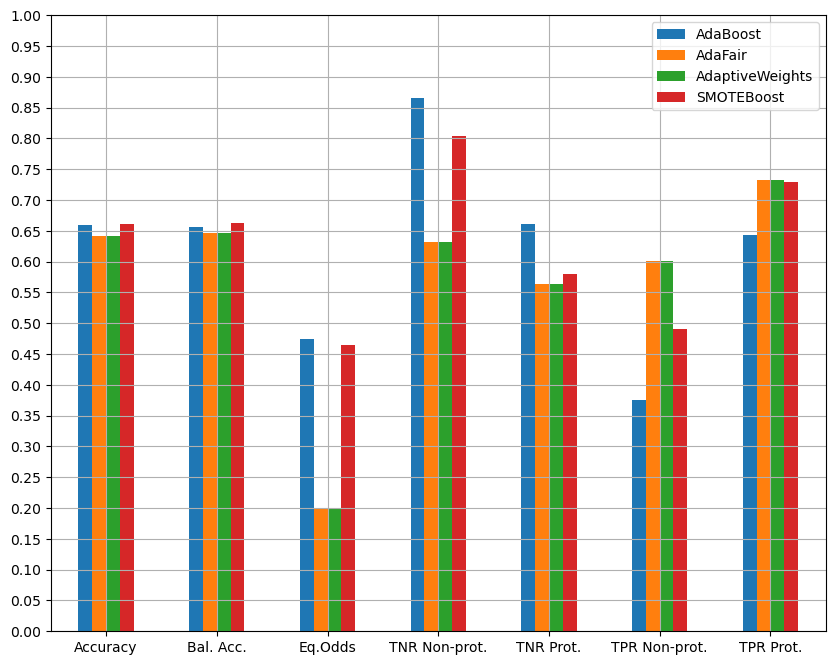

'Mean scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.659317,0.655692,0.473736,0.866225,0.661275,0.375042,0.643828
AdaFair,0.642016,0.646507,0.199264,0.632014,0.564210,0.601753,0.733213
AdaptiveWeights,0.642016,0.646507,0.199264,0.632014,0.564210,0.601753,0.733213
SMOTEBoost,0.660455,0.662492,0.465311,0.804730,0.579336,0.490118,0.730035


'Std of scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.010371,0.010844,0.221917,0.058628,0.050842,0.097383,0.051862
AdaFair,0.011731,0.017878,0.082693,0.127953,0.105001,0.143385,0.139381
AdaptiveWeights,0.011731,0.017878,0.082693,0.127953,0.105001,0.143385,0.139381
SMOTEBoost,0.017707,0.015970,0.154865,0.064579,0.066632,0.094270,0.048008


In [12]:
results_compas = pd.read_csv("results/compas_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_compas)
display('Mean scores for COMPAS dataset', mean)
display('Std of scores for COMPAS dataset', std)